In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import matplotlib
import cartopy.crs as ccrs # Projections
import cartopy.feature as cfeature
import cartopy
import datetime

In [2]:
sentinel_data_A = pd.read_csv("./Sentinel_3A_water_level_Version0.csv")

In [3]:
sentinel_data_A = sentinel_data_A.rename(
    columns={
        "Date (YYYYMMDD)" : "date",
        "Lake_name" : "lake_name",
        "Latitude" : "latitude",
        "Longitude" : "longitude",
        "Relaive_orbit" : "relative_orbit",
        "Lake water level (m)" : "lake_water_level"
    }
)

In [4]:
# Isolate Lake Winnipeg data
lake_winnipeg = sentinel_data_A[
    sentinel_data_A["lake_name"] == "Winnipeg"
]

In [5]:
pd.unique(lake_winnipeg[
    lake_winnipeg["relative_orbit"] == pd.unique(lake_winnipeg["relative_orbit"])[0]
]["date"])

array([20160401, 20160428, 20160525, 20160621, 20160718, 20160814,
       20160910, 20161007, 20161103, 20161130, 20161227, 20170123,
       20170219, 20170318, 20170414, 20170511, 20170607, 20170704,
       20170731, 20170827, 20170923, 20171020, 20171116, 20171213,
       20180109, 20180205, 20180304, 20180331, 20180427, 20180620,
       20180717, 20180813, 20180909, 20181006, 20181102, 20181129,
       20181226, 20190122, 20190218, 20190317, 20190510, 20190606,
       20190703, 20190730, 20190826, 20210604, 20210701, 20210728,
       20210824, 20210920])

## Plot ground track along Lake Winnipeg

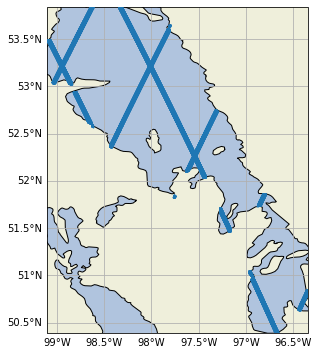

In [6]:
# Get the extent from the data
extent = [
    lake_winnipeg["longitude"].min(),
    lake_winnipeg["longitude"].max(),
    lake_winnipeg["latitude"].min(),
    lake_winnipeg["latitude"].max(),
]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

# High resolution lakes
lakes_50m = cfeature.NaturalEarthFeature('physical', 'lakes', '10m')

# Land, river, and lakes
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.RIVERS)
ax.add_feature(lakes_50m, facecolor='lightsteelblue',edgecolor='black')

# Plot altimetry points
ax.scatter(
    x=np.array(lake_winnipeg["longitude"]),
    y=np.array(lake_winnipeg["latitude"]),
    zorder=10,
    s=1
)

# Format gridlines
# https://scitools.org.uk/cartopy/docs/latest/gallery/gridlines_and_labels/gridliner.html
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()

## Explore Outliers

### Distribution of Water Levels... ignore $\mu\pm2\sigma$?
I sketch the idea below, but I'm not sure it's a good idea to actually implement

In [7]:
lake_water_mean = lake_winnipeg["lake_water_level"].mean()
lake_water_std = lake_winnipeg["lake_water_level"].std()
print("The mean lakewater level is %0.2f and the standard deviation is %02f"%(lake_water_mean, lake_water_std))

The mean lakewater level is 217.27 and the standard deviation is 1.164889


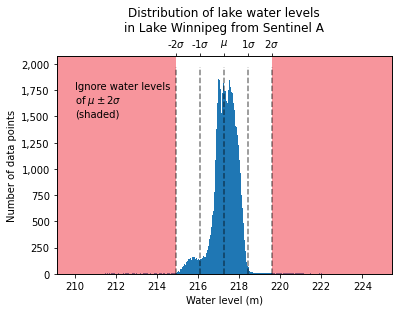

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(
    x=lake_winnipeg["lake_water_level"],
    bins=np.linspace(
        lake_water_mean - 5 * lake_water_std,
        lake_water_mean + 5 * lake_water_std,
        500
    )
)
ax.set_xlim(
    [
        lake_water_mean - 7 * lake_water_std,
        lake_water_mean + 7 * lake_water_std,
    ]
)

ax.axvspan(
    xmin=ax.get_xlim()[0],
    xmax=lake_water_mean - 2 * lake_water_std,
    facecolor="#F02D3A",
    alpha=0.5
)
ax.axvspan(
    xmin=lake_water_mean + 2 * lake_water_std,
    xmax=ax.get_xlim()[1],
    facecolor="#F02D3A",
    alpha=0.5
)


vline_water_levels = [lake_water_mean + i * lake_water_std for i in range(-2,3)]
ax.vlines(
    x=vline_water_levels,
    ymin=ax.get_ylim()[0],
    ymax=ax.get_ylim()[1],
    color='k',
    linestyle='--',
    alpha=0.5
)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
ax.set_xlabel("Water level (m)")
ax.set_ylabel("Number of data points")

ax1 = ax.twiny()
ax1.set_xlim(
    ax.get_xlim()
)
ax1.set_xticks(
    [lake_water_mean + i * lake_water_std for i in range(-2, 3)]
)
ax1.set_xticklabels(
    [
        r'-2$\sigma$',
        r'-1$\sigma$',
        r'$\mu$',
        r'1$\sigma$',
        r'2$\sigma$',
    ]
)

ax.text(210, 1500, 'Ignore water levels\n' + r'of $\mu  \pm2\sigma$' + '\n(shaded)')
plt.title("Distribution of lake water levels\nin Lake Winnipeg from Sentinel A")
plt.show()

### Water levels in different times of year.
There is ice cover in winter. Take summary stats of winter and non-winter and see how different they are.
I'm not sure this is particularly informative.

In [9]:
lake_winnipeg.head()

,date,lake_name,latitude,longitude,relative_orbit,lake_water_level
228868,20160401,Winnipeg,51.860057,-96.819518,283,217.4011
228869,20160401,Winnipeg,51.857120,-96.820913,283,217.5197
228870,20160401,Winnipeg,51.854183,-96.822309,283,217.2064
228871,20160401,Winnipeg,51.851245,-96.823704,283,217.3213
228872,20160401,Winnipeg,51.848308,-96.825099,283,217.3166


In [10]:
def add_winter_column(lake_winnipeg):
    # Add a column to indicate if the date is in winter or not.
    lake_winnipeg.loc[:, "date_as_datetime"] = pd.to_datetime(lake_winnipeg.loc[:, "date"], format="%Y%m%d")
    lake_winnipeg.loc[:, "month"] = lake_winnipeg["date_as_datetime"].apply( lambda x: x.month)
    lake_winnipeg.loc[:, "day"] = lake_winnipeg["date_as_datetime"].apply( lambda x: x.day)
    lake_winnipeg.loc[:, "winter"] = ((lake_winnipeg["month"] < 4) | (lake_winnipeg["month"] > 10))
    return lake_winnipeg

def remove_winter_column(lake_winnipeg):
    lake_winnipeg = lake_winnipeg.drop(columns=["winter", "month", "day", "date_as_datetime"])
    return lake_winnipeg

In [11]:
lake_winnipeg = add_winter_column(lake_winnipeg)

/var/folders/fq/5jxrrbnx17q2sdybczkrrlr00000gn/T/ipykernel_24580/2287572897.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lake_winnipeg.loc[:, "date_as_datetime"] = pd.to_datetime(lake_winnipeg.loc[:, "date"], format="%Y%m%d")
/var/folders/fq/5jxrrbnx17q2sdybczkrrlr00000gn/T/ipykernel_24580/2287572897.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lake_winnipeg.loc[:, "month"] = lake_winnipeg["date_as_datetime"].apply( lambda x: x.month)
/var/folders/fq/5jxrrbnx17q2sdybczkrrlr00000gn/T/ipykernel_

The mean lake water level in winter (Nov - March) is 216.97 m.
The mean lake water level in non-winter (Apr - Oct) is 217.41 m.

In [12]:
lake_winnipeg.loc[
    lake_winnipeg["winter"] == True,
    "lake_water_level"
].describe()

count    35584.000000
mean       216.977128
std          1.037623
min        187.942875
25%        216.655480
50%        217.051439
75%        217.488527
max        227.617834
Name: lake_water_level, dtype: float64

In [13]:
lake_winnipeg.loc[
    lake_winnipeg["winter"] == False,
    "lake_water_level"
].describe()

count    72920.000000
mean       217.409069
std          1.196905
min        183.408658
25%        217.159186
50%        217.483098
75%        217.780306
max        235.595841
Name: lake_water_level, dtype: float64

In [14]:
#lake_winnipeg = remove_winter_column(lake_winnipeg)

## Errors and Outliers
### Error: Calculate Absolute Deviance from the Mean (ADM)
Take the median along each track, and then subtract it from all the measurements. Most measurements have an error well below 0.25 m. The DAHITI paper suggest to reject measurements whose ADM is 5 cm. or greater. Perhaps we can be more forgiving and select 25 cm.

In the ideal world, we'd make a sliding box of 1.5 km along each track. We'd calculate the mean in this box and subtract it from the measurement.

Each day seems to be a single track. (See below, play with number_of_tracks. Set it to 1, 2, 3, ...)

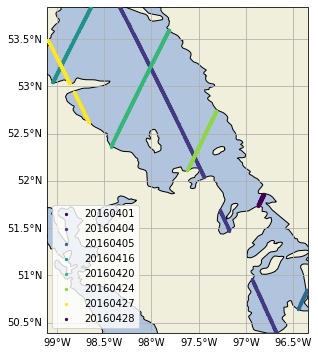

In [15]:
# Change this parameter
number_of_tracks = 8

# Make the cartopy map the background
extent = [
    lake_winnipeg["longitude"].min(),
    lake_winnipeg["longitude"].max(),
    lake_winnipeg["latitude"].min(),
    lake_winnipeg["latitude"].max(),
]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
lakes_50m = cfeature.NaturalEarthFeature('physical', 'lakes', '10m')
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.RIVERS)
ax.add_feature(lakes_50m, facecolor='lightsteelblue',edgecolor='black')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# Plot altimetry points
number_of_colours = 7
cmap = matplotlib.cm.get_cmap('viridis')
colours = cmap(np.linspace(0, 1, number_of_colours))
for i, date in enumerate(pd.unique(lake_winnipeg["date"])[0:number_of_tracks]):
    ax.scatter(
        x=lake_winnipeg.loc[
            lake_winnipeg["date_as_datetime"] == pd.to_datetime(date, format="%Y%m%d"),
            "longitude"
        ],
        y=lake_winnipeg.loc[
            lake_winnipeg["date_as_datetime"] == pd.to_datetime(date, format="%Y%m%d"),
            "latitude"
        ],
        s=5,
        color=colours[i%number_of_colours],
        label=date,
        zorder=10
    )
ax.legend()
plt.show()

In [16]:
def add_adm_error(lake_winnipeg):
    lake_winnipeg["error"] = 0
    unique_dates = pd.unique(lake_winnipeg["date"])
    for date in unique_dates:
        median_water_level = lake_winnipeg.loc[
            lake_winnipeg["date"] == date,
            "lake_water_level"
        ].median()
        lake_winnipeg.loc[
            lake_winnipeg["date"] == date,
            "error"
        ] = lake_winnipeg.loc[
            lake_winnipeg["date"] == date,
            "lake_water_level"
        ].apply(lambda x: np.abs(x - median_water_level))
    return lake_winnipeg

def remove_adm_error(lake_winnipeg):
    lake_winnipeg = lake_winnipeg.drop(columns=["error"])
    return lake_winnipeg

In [17]:
lake_winnipeg = add_adm_error(lake_winnipeg)

/var/folders/fq/5jxrrbnx17q2sdybczkrrlr00000gn/T/ipykernel_24580/1463478029.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lake_winnipeg["error"] = 0
/var/folders/fq/5jxrrbnx17q2sdybczkrrlr00000gn/T/ipykernel_24580/1463478029.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lake_winnipeg.loc[


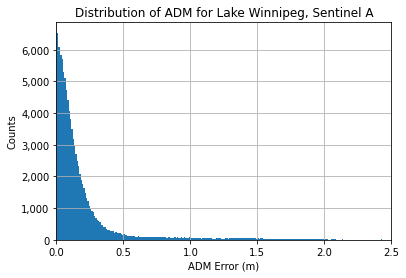

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(
    lake_winnipeg["error"],
    bins=np.linspace(0, 5, 501)
)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
ax.set_xlabel("ADM Error (m)")
ax.set_ylabel("Counts")
ax.grid(True)
ax.set_xlim([0, 2.5])
plt.title("Distribution of ADM for Lake Winnipeg, Sentinel A")
plt.show()

### Outliers: Apply Linear SV regression
Along a track of data, apply a linear (flat) SV regression. This gives "wide margin" regression. DAHITI suggests to ignore points that sit outside the margins of +/- 5cm. Perhaps we can be more generous to 25 cm?

Plot the water levels against the longitude coordinate. It seems we can get away with this, since none of our tracks are vertical (i.e. at const longitude)

In [19]:
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression

In [20]:
# Illustrate for one date
date = pd.unique(lake_winnipeg["date"])[5]
X = np.array(
    lake_winnipeg.loc[
        lake_winnipeg["date"] == date,
        "longitude"
    ]
).reshape(-1, 1)
y = np.array(
    lake_winnipeg.loc[
        lake_winnipeg["date"] == date,
        "lake_water_level"
    ]
).ravel()
lin_reg = LinearRegression()
lin_reg.fit(X, y)
# svm_reg = LinearSVR(epsilon=0.05, max_iter=1000, C=1e6)
# svm_reg.fit(X, y)

LinearRegression()

In [21]:
date

20160424

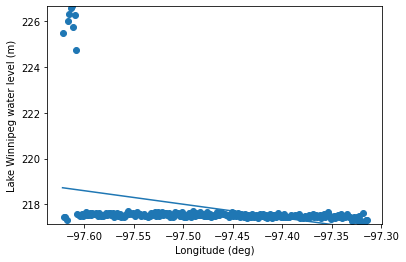

In [22]:
fig = plt.figure()

# Set x-range (i.e. longitude range)
longitude_range = np.linspace(
    lake_winnipeg.loc[
        lake_winnipeg["date"] == date,
        "longitude"
    ].min(),
    lake_winnipeg.loc[
        lake_winnipeg["date"] == date,
        "longitude"
    ].max(),
    100
)

# water_levels_predicted = svm_reg.predict(longitude_range.reshape(100, 1))
water_levels_predicted = lin_reg.predict(longitude_range.reshape(100, 1))

ax = fig.add_subplot(111)
ax.plot(longitude_range, water_levels_predicted)
# ax.plot(longitude_range, water_levels_predicted - svm_reg.epsilon, "k--")
# ax.plot(longitude_range, water_levels_predicted + svm_reg.epsilon, "k--")
ax.scatter(
    lake_winnipeg.loc[
        lake_winnipeg["date"] == date,
        "longitude"
    ],
    lake_winnipeg.loc[
        lake_winnipeg["date"] == date,
        "lake_water_level"
    ]
)
ax.set_ylim(
    [
        lake_winnipeg.loc[
            lake_winnipeg["date"] == date,
            "lake_water_level"
        ].min(),
        lake_winnipeg.loc[
            lake_winnipeg["date"] == date,
            "lake_water_level"
        ].max(),
    ]
)
ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Lake Winnipeg water level (m)")
plt.show()

### Outliers: Reject $\pm2\sigma$ and then take the median
It does not seem easy to constrain the slope to zero, so try a different approach. For each track, take the mean and std, and reject points that are outside of $\mu\pm2\sigma$. Take the median of this sample, and accept points that are within $\pm5$ cm?

# Kalman Filtering

In [23]:
# Work on one time step and then put a loop over time steps

# Model:
# l_k = A_k * x_k - v_k
# There are n=1 grid points on the lake
# There are m_k=42 points on 2016-04-01 and m_k=875 points on 2016-04-04
# Dimensions:
#     l_k: (m_k, 1); lake water observations at time t_k
#     A_k: (m_k, n); ones for each grid point that we have an observation at time t_k
#     x_k: (n, 1); the model state we are after
#     v_k: (m_k, 1); residuals from the observations

# Uncertainty in the lake water level:
# sigma_{ll, k} = I * s_kl
# Dimensions:
#    sigma_{ll, k} = (m_k, m_k); assume each measurement is indepdendent. Diagonal.
#    s_{kl} = (m_k, 1); error in each measurement at time t_k   

In [178]:
class KalmanFilter:
    def __init__(self):
        self.m_k = 0 # number of points in this time step
        self.x_k_prior = 0 # x_k prior, just a #
        self.x_k = 0 # x_k update, just a #
        self.A_k = 0 # model matrix (m_k, 1)
        self.sigma_xx_k_prior = 0 # process noise, prior; just a #
        self.sigma_ll_k_prior = 0 # observation noise, prior; (m_k, m_k)
        self.sigma_xx_k = 0 # process noise, update; just a #
        self.sigma_ll_k = 0 # observation noise, update; (m_k, m_k)
        self.l_k = 0 # observations; (m_k, 1)
        self.K_k = 0 # Kalman gain
        
    def initialize(self, lake_data_0):
        # lake_data_0 is the lake data for the zeroth time step.
        # In our Lake Winnipeg case, it will be something like this;
        # lake_data_0 = lake_winnipeg.loc[
        #    lake_winnipeg["date"] = pd.unique(lake_winnipeg["date"])[0]
        #]
        
        # Initialize the x_k_prior to the lake water level that has the lowest
        # error estimate
        water_level_with_smallest_error = lake_data_0.loc[
            lake_data_0['error'].idxmin()
        ]['lake_water_level']
        self.x_k_prior = water_level_with_smallest_error
        
        # Initialize the process noise to unity
        self.sigma_xx_k_prior = 1.
        
        # Define the variables from the data
        self.input_new_data(lake_data_0)
        
    def input_new_data(self, lake_data):
        # Set the number of points in this time step
        self.m_k = len(lake_data)
        
        # Set the model matrix
        self.A_k = np.ones((self.m_k, 1))
        
        # Set the observation noise matrix.
        # In accordance with the KalmanNet paper, this is only
        # the R, and not the S_{t|t-1}.
        self.sigma_ll_k_prior = np.zeros((self.m_k, self.m_k))
        np.fill_diagonal(self.sigma_ll_k_prior, lake_data["error"])
        # To make it S_{t|t-1}, add
        # + np.matmul(A_k, np.transpose(A_k)) * sigma_xx_k_prior
        
        # Initialize the observations
        self.l_k = np.array(lake_data["lake_water_level"]).reshape(self.m_k, 1)
    
    def calculate_kalman_gain(
        self,
        sigma_xx_k_prior, # Process noise, prior
        sigma_ll_k_prior, # Observation noise, prior
        A_k, # model matrix
    ):
        return np.matmul(
            sigma_xx_k_prior * np.transpose(A_k),
            np.linalg.pinv(
                sigma_ll_k_prior + sigma_xx_k_prior * np.matmul(
                    A_k,
                    np.transpose(A_k)
                )
            )
        )
        
    def update(self):
        self.K_k = self.calculate_kalman_gain(
            self.sigma_xx_k_prior,
            self.sigma_ll_k_prior,
            self.A_k
        )
        
        # Update state variable
        self.x_k = self.x_k_prior + np.matmul(
            self.K_k,
            self.l_k - self.A_k * self.x_k_prior
        ).item()

        # Update sigma_xx
        self.sigma_xx_k = (1. - np.matmul(self.K_k, self.A_k).item()) - self.sigma_xx_k_prior
    
    def predict(self): # Is a better name predict_next_prior?
        self.x_k_prior = self.x_k
        self.sigma_xx_k_prior = self.sigma_xx_k

In [179]:
times = pd.unique(lake_winnipeg["date"])
lake_water_levels = np.zeros(np.array(times).shape)
oHai = KalmanFilter()

for i, time in enumerate(times):
    # Initialize
    if i == 0:
        oHai.initialize(
            lake_winnipeg.loc[
                lake_winnipeg["date"] == time
            ]
        )
    else:
        oHai.input_new_data(
            lake_winnipeg.loc[
                lake_winnipeg["date"] == time
            ]
        )
     # Update
    oHai.update()
    
    # Get the lake water levels
    lake_water_levels[i] = oHai.x_k # This should be a variable like y_k which is just x_k
    
    print(time)
    
    oHai.predict()

20160401
20160404
20160405
20160416
20160420
20160424
20160427
20160428
20160501
20160502
20160513
20160517
20160521
20160524
20160525
20160528
20160529
20160609
20160613
20160617
20160620
20160621
20160624
20160625
20160706
20160710
20160714
20160717
20160718
20160721
20160722
20160802
20160806
20160810
20160813
20160814
20160817
20160818
20160829
20160902
20160906
20160909
20160910
20160913
20160914
20160925
20160929
20161003
20161006
20161007
20161010
20161011
20161022
20161026
20161030
20161102
20161103
20161106
20161107
20161118
20161122
20161126
20161129
20161130
20161203
20161204
20161215
20161219
20161223
20161226
20161227
20161230
20161231
20170111
20170115
20170119
20170122
20170123
20170126
20170127
20170207
20170211
20170215
20170218
20170219
20170222
20170223
20170306
20170310
20170314
20170317
20170318
20170321
20170322
20170402
20170406
20170410
20170413
20170414
20170417
20170418
20170429
20170503
20170507
20170510
20170511
20170514
20170526
20170530
20170603
20170606
2

In [180]:
# date = datetime.strptime(a, '%Y%m%d').strftime('%m/%d/%Y')
time_as_datetime = pd.to_datetime(times, format="%Y%m%d")

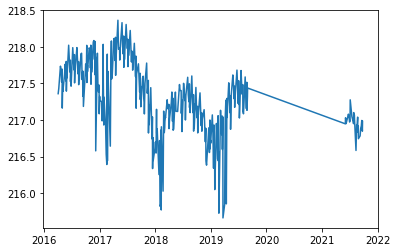

In [181]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(time_as_datetime, lake_water_levels)
plt.show()